In [1]:
from envs.train_env import Electric_Car
from models.baseline import BaselineModel
from models.baseline2 import BaselineModel2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from models.tabular_qlearning import TabularQLearning
from envs.feature_engineering import DataHelper
import torch

In [2]:
dh = DataHelper()

def learn(env, model):
    states, rewards, infos = [], [], []
    truncated = False
    terminated = False
    while(terminated == False and truncated == False):
        action = model.predict(env)
        obs, reward, termination, truncation, info = env.step(action)
        new_obs = dh.process_data(obs)

        states.append(new_obs)
        rewards.append(reward)
        terminated = termination
        truncated = truncation
        infos.append(info)

    return states, rewards, terminated, truncated, infos

Please wait, the algorithm is learning! The current simulation is 0
Please wait, the algorithm is learning! The current simulation is 2
The simulation is done!


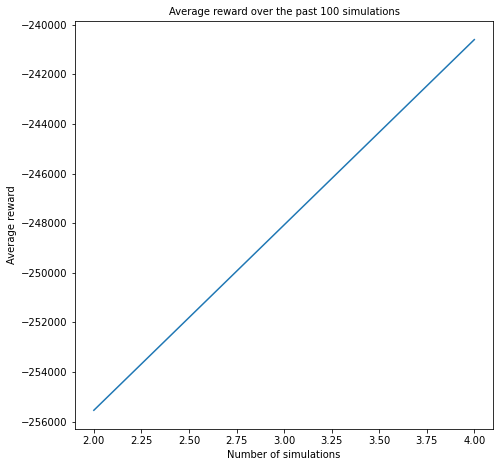

IndexError: index 492 is out of bounds for axis 2 with size 24

In [3]:
data_path_train = 'data/train.xlsx'
data_path_test = 'data/validate.xlsx'

simulations = 4
simulations_per_average = 2
learning_rate = 0.8
epsilon = 0.05
epsilon_decay = 100
adaptive_epsilon = False
adapting_learning_rate = False
discount_rate = 0.2
bin_size = 20

model = TabularQLearning(data_path_train, discount_rate, bin_size)
#torch.save(model.target_network.state_dict(), 'model_checkpoints/discount_05.pth')
model.train(simulations, simulations_per_average, learning_rate, epsilon, epsilon_decay, adaptive_epsilon, adapting_learning_rate)
model.visualize_rewards()
model.play(data_path_test)